<h1> Train and validate CNN model for Invasive Ductal Carcinoma classification </h1>

<p> IDC accounts for the vast mayority of breast cancers. The clasification accuracy of 84.23% has been reported in 
 <a href="https://spie.org/Publications/Proceedings/Paper/10.1117/12.2043872?SSO=1 "> the original publication. </a></p>
<p> Data is dowlodaed from <a href="https://www.kaggle.com/paultimothymooney/breast-histopathology-images"> Kaggle  </a> and pre-arranged using "Arange_dataset.ipynb" available in this repository. </p>
<p> The exact arhitecture of the CNN is decided upon exploratory analysis of the train and validation error on the substet of 30,000 and 20,000 images respecitly. To create exploratory data set "Create_h5_Dataset_4Exploratory_Analysis.ipynb" is used while "Exploratory_Anylsis.ipynb" is used for the analysis.</p>
<h3> Package information: </h3>
<p>Anaconda contained packages: numpy, pandas, sklearn, matplotlib </p>
    
<p>Aditional packages: <b>Tensorflow 2.2</p></b>

<i>pip install --upgrade pip</i>
To instal tensorflow:
<i>pip install tensorflow </i>
To update Tensorflow:
<i>pip install --upgrade tensorflow</i>

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Conv2D, BatchNormalization, Dense, Dropout, MaxPooling2D, Activation
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

# -- Define number of Epochs, the Batch Size, and global randon seed
NUM_EPOCHS = 5
BS = 100
tf.random.set_seed(0)

<p style = "color:orange; font-size:30px;"> Define the CNN model </p>

In [2]:
def Cancer_clasifier(input_shapes):
    
    X_input = Input(input_shapes)
    
    XX = Conv2D(8, kernel_size = (2,2), strides=(1, 1), padding = 'same', 
                kernel_initializer = GlorotNormal())(X_input)       
    XX = BatchNormalization(axis = -1)(XX)
    XX = Activation('relu')(XX)
    XX = MaxPooling2D(2,2)(XX)
 
    XX = Conv2D(16, kernel_size = (4,4), strides=(1, 1), padding = 'same')(XX)
    XX = BatchNormalization(axis = -1)(XX)
    XX = Activation('relu')(XX)
    XX = MaxPooling2D(2,2)(XX)
    
    # --- Output Layer
    XX = Flatten()(XX)
    
    XX = Dense(1, activation='sigmoid')(XX)
    
    model = Model(inputs = X_input, outputs = XX, name='Cancer_clasifier')
              
    return model

<p style = "color:orange; font-size:30px;">  Data generator </p>

Define the path to the data set. Be sure that you had run 'arrange_dataset' file before to create testing, validating and training subsets with "0" and "1" as subdirectories.

In [3]:
Path_to_traning = r"D:\DS_Course\Projects\FinalProject_BreastCancer\breast_cancer_data\arranged\training"
Path_to_validation = r"D:\DS_Course\Projects\FinalProject_BreastCancer\breast_cancer_data\arranged\validation"

print('Current working directory is')
%pwd

Current working directory is


'C:\\Users\\Oscar\\JUPITER_NOTEBOOKS\\CNN_BreastCancer'

In [4]:
image_shape = (50,50,3)
train_augmentation = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.03,
        horizontal_flip = True)
val_augmentation = ImageDataGenerator(rescale=1./255)

train_generator = train_augmentation.flow_from_directory(
        Path_to_traning,
        target_size = image_shape[:2],
        color_mode="rgb",
        batch_size = BS,
        class_mode = 'binary',
        shuffle=True)

validation_generator = val_augmentation.flow_from_directory(
        Path_to_validation,
        target_size = image_shape[:2],
        color_mode="rgb",
        batch_size = BS,
        class_mode = 'binary',
        shuffle=True)

Found 255815 images belonging to 2 classes.
Found 42660 images belonging to 2 classes.


In [5]:
# -- Check if the right classes are recognized by the DirectoryIterator 
train_generator.class_indices.keys()

dict_keys(['0', '1'])

<p style = "color:orange; font-size:30px;"> Train the model </p>

<p> In each Epoch validation accuracy is checked and if it has imporved - model weights are saved in hdf5 file </p>

In [6]:
# -- Create the model
my_cancer_model = Cancer_clasifier(image_shape)
# -- Print model summary
my_cancer_model.summary()

# -- Define the optimizer
opt = Adam(learning_rate=0.0001)
# -- Compile the model
my_cancer_model.compile(optimizer = opt, loss='binary_crossentropy', metrics=['accuracy'])

# create the checkpoint for the model with best accuracy on validation set
checkpoint_filepath = 'model.{epoch:02d}-{val_accuracy:.2f}.h5'
checkpoint = ModelCheckpoint(filepath = checkpoint_filepath, monitor='val_accuracy', mode='max', verbose=1, 
                             save_best_only = True, save_weights_only = False, save_freq = 'epoch')

# -- Train the model
#history = my_cancer_model.fit(train_generator, validation_data = validation_generator, 
#                              epochs = NUM_EPOCHS, callbacks=[checkpoint])
history = my_cancer_model.fit(train_generator, validation_data = validation_generator, epochs = NUM_EPOCHS, 
                              callbacks=[checkpoint], 
                              steps_per_epoch = len(train_generator),
                              validation_steps = len(validation_generator))

Model: "Cancer_clasifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 50, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 50, 50, 8)         104       
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 50, 8)         32        
_________________________________________________________________
activation (Activation)      (None, 50, 50, 8)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 16)        2064      
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 25, 16)   

<p style = "color:orange; font-size:30px;"> Saving the model </p>
<p> Save the model using joson, weights in h5 a file and model history as DataFrame </p>

In [7]:
# serialize model to JSON
model_json = my_cancer_model.to_json()
with open("Cancer_clasifier_model.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
my_cancer_model.save_weights("Cancer_clasifier_LastWeights.h5")

# Save model history with json 
hist_df = pd.DataFrame(history.history) 
# save to json:  
hist_json_file = 'History_14May_6Epoch.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

<p style = "color:orange; font-size:30px;"> Plot the results </p>
<p> Model loss and accuracy are ploted as number of Epochs </p>

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


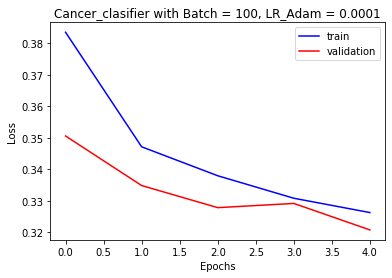

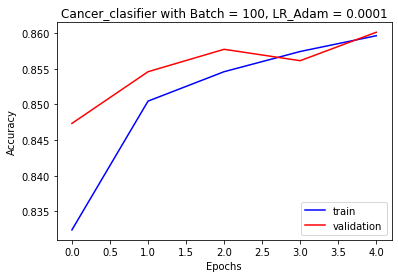

In [8]:
# -- Plot the Loss as a function of number of Epochs 
plt.figure()
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'r')
plt.legend(['train', 'validation'], loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Cancer_clasifier with Batch = 100, LR_Adam = 0.0001')
plt.savefig('Cancer_clasifier_Loss.eps')
# -- Plot the Accuracy as a function of number of Epochs 
plt.figure()
plt.plot(history.history['accuracy'], 'b')
plt.plot(history.history['val_accuracy'], 'r')
plt.legend(['train', 'validation'], loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Cancer_clasifier with Batch = 100, LR_Adam = 0.0001')
plt.savefig('Cancer_clasifier_Accuracy.eps')

<p style = "color:orange; font-size:30px;"> Validate the model on the test set </p>

In [9]:
#Run this cell if you want to load saved model and weights

from tensorflow.keras.models import model_from_json
json_file = open('Cancer_clasifier_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
my_cancer_model = model_from_json(loaded_model_json)
my_cancer_model.load_weights('model.05-0.86.h5')
image_shape = (50,50,3)

In [15]:
print('Predicting the classes on the test set and calculating the confusion matrix ..')
Path_to_test = r"D:\DS_Course\Projects\FinalProject_BreastCancer\breast_cancer_data\arranged\testing"

test_augmentation = ImageDataGenerator(rescale=1./255)
test_generator = test_augmentation.flow_from_directory(
        Path_to_test,
        target_size = image_shape[:2],
        color_mode="rgb",
        batch_size = BS,
        class_mode = 'binary',
        shuffle=False)

# ---- Predictions from the model on test set
predicted_indices = my_cancer_model.predict(test_generator, verbose = 1, steps = len(test_generator))
predicted_indices[predicted_indices < 0.5] = 0
predicted_indices[predicted_indices >= 0.5] = 1

# --- Create Confusion matrix 
cm = confusion_matrix(test_generator.classes, predicted_indices)
total = sum(sum(cm))
# --- Calculate and print acc, spec & sens
accuracy = (cm[0,0]+cm[1,1])/total
specificity = cm[1,1]/(cm[1,0]+cm[1,1])
sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])

print('Confussion matrix is \n', cm)
print('Accuracy:', accuracy)
print('Sensitivity', sensitivity)
print('Specificity', specificity)

Predicting the classes on the test set and calculating the confusion matrix ..
Found 99906 images belonging to 2 classes.
1000/1000 [==============================] - 127s 127ms/step
Confussion matrix is 
 [[66411  5040]
 [ 8909 19546]]
Accuracy: 0.8603787560306688
Sensitivity 0.92946214888525
Specificity 0.6869091548058338
